### In this part, we would be defining one of the most important metrics, i.e., Customer Lifetime Value

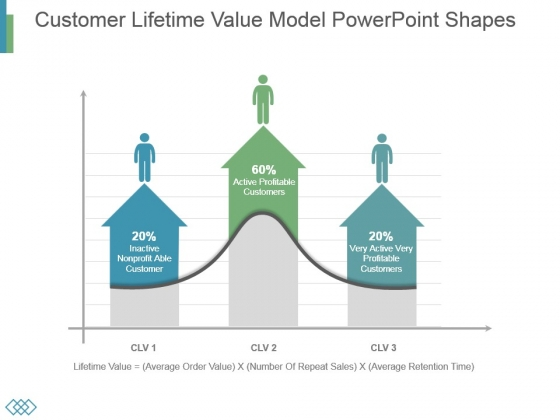

Companies invest a lot in their customers for acquisition, advertisement, and many other promotional campaigns to generate revenue and be profitable. Implementing these startegies, some customers may turn out to be most valuable, but there are always some customers who can pull down this profitability. We already have found the behaving patterns for different segments in Part 3 and now we would be using that to find out CLV.

We are going to build a machine learning model that predicts our Customer Lifetime Value

**_Lifetime Value_** **_=_** **_Total Gross Revenue_** **_-_** **_Total Cost_**
#### In this case, I am defining the time frame of 6 months, but it totally depends on the industry and the business model. I will be using Customer Segmentation data which we derived in part 3.

In [13]:
# import libraries
# importing required libraries
from __future__ import division
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# hide warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [7]:
# reading our dataset
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [95]:
# UK Data
df_uk = df.query("Country == 'United Kingdom'").reset_index(drop=True)

In [71]:
# create 3m and 6m dataframes
df_3m = df_uk[(df_uk.InvoiceDate < date(2011,6,1)) & (df_uk.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
df_6m = df_uk[(df_uk.InvoiceDate >= date(2011,6,1)) & (df_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

In [60]:
# creating df_customer for assigning cluster
df_customer = pd.DataFrame(df_3m['CustomerID'].unique())
df_customer.columns = ['CustomerID']

# Order Cluster Method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [61]:
# calculate recency score
df_max_purchase = df_3m.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days
df_customer = pd.merge(df_customer, df_max_purchase[['CustomerID', 'Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Recency']])
df_customer['RecencyCluster'] = kmeans.predict(df_customer[['Recency']])

df_customer = order_cluster('RecencyCluster', 'Recency', df_customer, False)

In [62]:
# Calculate frequency score
df_frequency = df_3m.groupby('CustomerID')['InvoiceDate'].count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']
df_customer = pd.merge(df_customer, df_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Frequency']])
df_customer['FrequencyCluster'] = kmeans.predict(df_customer[['Frequency']])

df_customer = order_cluster('FrequencyCluster', 'Frequency', df_customer, True)

In [63]:
# Calculate monetary score
df_3m['Monetary'] = df_3m['UnitPrice'] * df_3m['Quantity']
df_monetary = df_3m.groupby('CustomerID')['Monetary'].sum().reset_index()
df_customer = pd.merge(df_customer, df_monetary, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Monetary']])
df_customer['MonetaryCluster'] = kmeans.predict(df_customer[['Monetary']])

df_customer = order_cluster('MonetaryCluster', 'Monetary', df_customer, True)

In [64]:
# Calculating the overall score
df_customer['RFM_Score'] = df_customer['RecencyCluster'] + df_customer['FrequencyCluster'] + df_customer['MonetaryCluster']
df_customer['Segment'] = 'Low-Value'
df_customer.loc[df_customer['RFM_Score'] > 2, 'Segment'] = 'Mid-Value'
df_customer.loc[df_customer['RFM_Score'] > 4, 'Segment'] = 'High-Value'

In [65]:
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFM_Score,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


### Calculating 6 months LTV for each customer

#### Since there is no cost specified in our dataset, we will difrectly use Monetary value as our LTV

In [73]:
# Calculate the revenue in a new dataframe
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_customer_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_customer_6m.columns = ['CustomerID', 'M6_Revenue']

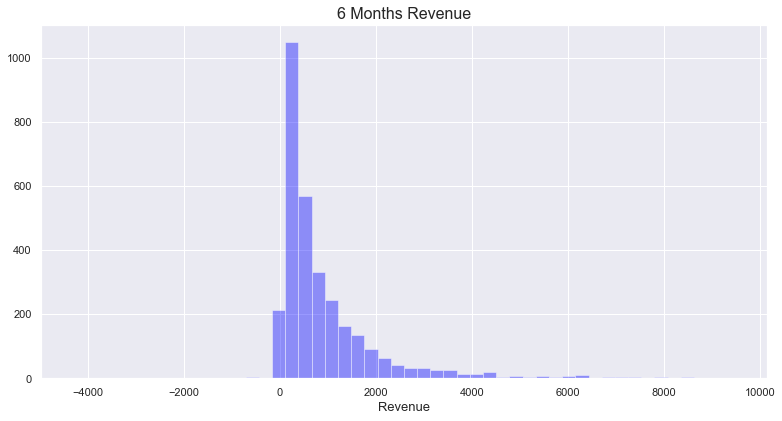

In [74]:
# Plotting our LTV Distribution
plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid')
sns.distplot(df_customer_6m.query("M6_Revenue < 10000")['M6_Revenue'], kde= False, color='blue')
plt.title("6 Months Revenue", fontsize = 16);
plt.xlabel("Revenue", fontsize=13);

_Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model._

### Finding Correlations

#### We will now merge our 3 months and 6 months data to find the correlations between LTV and the feature set we created

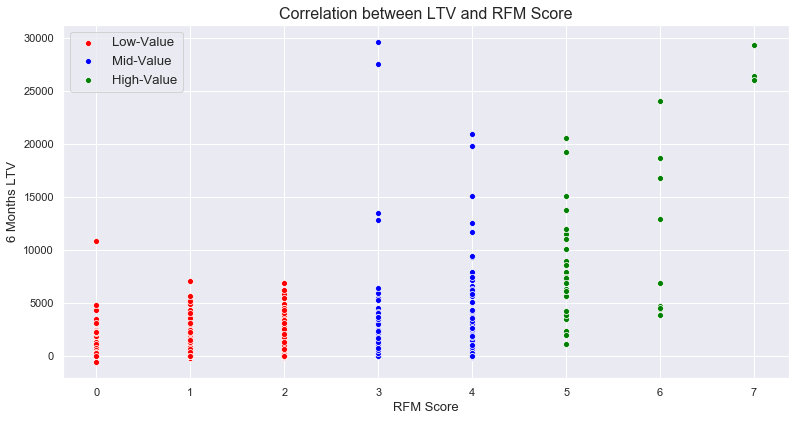

In [77]:
df_merge = pd.merge(df_customer, df_customer_6m, on= 'CustomerID', how='left')
df_merge = df_merge.fillna(0)

df_graph = df_merge.query("M6_Revenue < 30000")

# Visulaizing the correlation

plt.figure(figsize=(13,6.5))
sns.set(style='darkgrid', font_scale=1.2);
x1 = df_graph.query("Segment == 'Low-Value'")['RFM_Score']
y1 = df_graph.query("Segment == 'Low-Value'")['M6_Revenue']

x2 = df_graph.query("Segment == 'Mid-Value'")['RFM_Score']
y2 = df_graph.query("Segment == 'Mid-Value'")['M6_Revenue']

x3 = df_graph.query("Segment == 'High-Value'")['RFM_Score']
y3 = df_graph.query("Segment == 'High-Value'")['M6_Revenue']


sns.scatterplot(x1, y1, color = 'red', label = 'Low-Value')
sns.scatterplot(x2, y2, color = 'blue', label = 'Mid-Value')
sns.scatterplot(x3, y3, color = 'green', label = 'High-Value')

plt.title("Correlation between LTV and RFM Score", fontsize = 16)
plt.xlabel("RFM Score", fontsize = 13)
plt.ylabel("6 Months LTV", fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend();

_We can see a positive correlation here. High RFM Score means high LTV_

#### We will now create LTV segments using K Means as we have to differentiate the customers based on ther predicted LTV. Let us go with 3 segments as: 
- **Low LTV**
- **Mid LTV**
- **High LTV**

In [78]:
# Removing Outliers
df_merge = df_merge[df_merge['M6_Revenue'] < df_merge['M6_Revenue'].quantile(0.99)]

In [80]:
# Creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merge[['M6_Revenue']])
df_merge['LTVCluster'] = kmeans.predict(df_merge[['M6_Revenue']])

# Order Cluster Number based on LTV
df_merge = order_cluster('LTVCluster', 'M6_Revenue', df_merge, True)

# Creating a new cluster dataframe
df_cluster = df_merge.copy()

#see details of the clusters
df_cluster.groupby('LTVCluster')['M6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


_With an average LTV of around **8.2K**, **Cluster 2** seems to be the best one and **cluster 0** is the worst with an average LTV of **396**._

### Data Preparation before training the ML Model

- We would be performing some sort of feature engineering such as converting categorical columns to numerical
- Checking the correlations of our features against our target variable, LTV Cluster
- Splitting our feature set and label as X and y (Using X to predict y)
- Create training and Test datasets

In [89]:
# Convert categorical columns to numerical
df_class = pd.get_dummies(df_cluster)
df_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFM_Score,M6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,858.09,0,0,0,1


In [90]:
# Correlations
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
M6_Revenue            0.845933
Monetary              0.600491
MonetaryCluster       0.467191
RFM_Score             0.373114
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.352387
RecencyCluster        0.236899
Segment_Mid-Value     0.168473
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: LTVCluster, dtype: float64

In [91]:
# Create X and y, X will be a feature set and y is the label - LTV
X = df_class.drop(['LTVCluster', 'M6_Revenue'], axis = 1)
y = df_class['LTVCluster']

# Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

### XGBoost Multiclassification Model

In [92]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective= 'multi:softprob', n_jobs=-1).fit(X_train, y_train)


print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.87
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        70
          1       0.82      0.50      0.62        18
          2       0.50      0.50      0.50         4

avg / total       0.86      0.87      0.86        92



### Conclusion

- **Precision and recall are acceptable for Cluster 0.**
- **For cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision).** - **Model successfully identifies 93% of actual cluster 0 customers (recall).** 
- **We really need to improve the model for other clusters. For example, we barely detect 56% of Mid LTV customers.** 

### Possible actions to improve future modeling:

- **Adding more features and improve feature engineering**
- **Try different models other than XGBoost**
- **Apply hyper parameter tuning to current model**
- **Add more data to the model if possible**